In [16]:
import os
import pandas as pd
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [22]:
positive_class_path = 'malaria/uab curated/1'
negative_class_path = 'malaria/uab curated/0'
positive_class_path2 = 'malaria/uah/1/'
negative_class_path2 = 'malaria/uah/0/'


### Step 1 : Data Extraction / Preprocessing
Combining the data sources to create a singular data source

In [50]:
def file_append(class_path):    
    image_array = []    
    curr_path = os.path.join(os.getcwd(),class_path)
    cnt = 0
    file_list = [k for k in os.listdir(curr_path) if '.png'  in k]
    for x in file_list:
        
        img_path = os.path.join(curr_path,x)

        img = imread(img_path)
#         img = rgb2gray(img)
        img = resize(img,(64,64,3))     ## Will need to change this resize parameter
        img = img.flatten()
        image_array.append(img)
        
    return image_array
    

pos_imgs_curated = file_append(positive_class_path)
pos_imgs_uah = file_append(positive_class_path2)

positive_df_curated  = pd.DataFrame(pos_imgs_curated)
positive_df_uah = pd.DataFrame(pos_imgs_uah)
# positive_df = pd.concat([positive_df_curated,positive_df_uah],ignore_index=True)
positive_df['y'] = 1

neg_imgs_curated = file_append(negative_class_path)
neg_df_cur  = pd.DataFrame(neg_imgs_curated)
neg_imgs_uah = file_append(negative_class_path2)
neg_df_uah  = pd.DataFrame(neg_imgs_uah)
# neg_df = pd.concat([neg_df_cur,neg_df_uah],ignore_index=True)
neg_df['y'] = 0

# plt.imshow(np.reshape(pos_imgs[2],(40,40,3)))
df = pd.concat([positive_df,neg_df,],ignore_index=True)


In [51]:
np.bincount(df.y)


array([1531, 1834])

### Step 2 : Standardizing the data

### Step 2: Splitting entire dataset into train and test sets

In [52]:
X,y = df[df.columns[:-1]],df['y']
X = X/255
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=121)



### Dimensionality reduction

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
pca = PCA(n_components=0.80)
pca_data = pca.fit_transform(X_train)
exp_var = pca.explained_variance_ratio_

In [55]:
pca_data.shape[1]

58

In [56]:
PC_labels = ['PC_'+ str(x) for x in range(1,pca_data.shape[1])]

0.8007300387121279

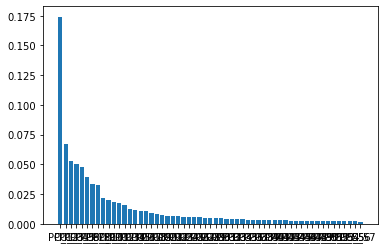

In [57]:
plt.bar(PC_labels,exp_var[:pca_data.shape[1]-1])
sum(exp_var[:pca_data.shape[1]])

In [58]:
pca_data.shape

(2355, 58)

## SVM Modelling

In [59]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [60]:
# X_test_new = pca.transform(X_test)
model = SVC(C=1.5,kernel='rbf',)


In [61]:
model = SVC(C=1.5,kernel='rbf')
model.fit(pca_data,y_train)
print(f"Train score: {model.score(pca_data,y_train)}")
print(f"Test score : {accuracy_score(y_test,model.predict(pca.transform(X_test)))}")


Train score: 0.9915074309978769
Test score : 0.9554455445544554


## SVM modelling with grid search CV

In [65]:
# parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.01,0.1,0.5,1]}
# grid_svc = SVC()
# clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)


parameters = {'kernel':['poly','rbf'], 'C':[0.01,0.05, 0.1,0.5,1,10]}
grid_svc = SVC()
clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)



In [132]:
clf.fit(pca_data, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10],
                         'kernel': ['poly', 'rbf']},
             verbose=2)

0.8102915951972556

In [1]:
import os

In [14]:
negative_class_path2 = 'malaria/uah/0/'
set([x.split('.')[1] for x in os.listdir(negative_class_path2)])

{'tiff'}

In [62]:
from sklearn.metrics import classification_report

In [64]:
print(classification_report(y_test,model.predict((pca.transform(X_test)))))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       434
           1       0.97      0.95      0.96       576

    accuracy                           0.96      1010
   macro avg       0.95      0.96      0.95      1010
weighted avg       0.96      0.96      0.96      1010

